Packages

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 22.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
import gc
import matplotlib.pyplot as plt
from tqdm import *

from catboost import CatBoostClassifier
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge

from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

Reading in the data sets -- if you're using Colab, make sure that you have already uploaded the required data sets and files before each run.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 读取训练数据和测试数据
data_ads = pd.read_csv('drive/MyDrive/train_data_ads.csv')
data_feeds = pd.read_csv('drive/MyDrive/train_data_feeds.csv')




Since the columns `ad_click_list_v#` are complicated in a sense, I choose to reencode them with the spirit of one-hot encoding. We see that for 7.6M rows there are about 280k unique strings; not too bad!

In [ ]:
# 自然数编码
def label_encode(series, series2):
    unique = list(series.unique())
    return series2.map(dict(zip(
        unique, range(series.nunique())
    )))

for col in ['ad_click_list_v001', 'ad_click_list_v002', 'ad_click_list_v003',
            'ad_close_list_v001', 'ad_close_list_v002', 'ad_close_list_v003']:
    data_ads[col] = label_encode(data_ads[col], data_ads[col])



In [ ]:
pd.set_option('display.max_columns', None)

data_ads

,log_id,label,user_id,age,gender,residence,city,city_rank,series_dev,series_group,emui_dev,device_name,device_size,net_type,task_id,adv_id,creat_type_cd,adv_prim_id,inter_type_cd,slot_id,site_id,spread_app_id,hispace_app_tags,app_second_class,app_score,ad_click_list_v001,ad_click_list_v002,ad_click_list_v003,ad_close_list_v001,ad_close_list_v002,ad_close_list_v003,pt_d,u_newsCatInterestsST,u_refreshTimes,u_feedLifeCycle
0,373250,0,100005,3,2,16,147,2,32,6,35,312,2117,7,14339,19319,6,1846,4,46,1,162,47,14,10.0,0,0,0,0,0,0,202206030326,39^220^16,0,15
1,373253,1,100005,3,2,16,147,2,32,6,35,312,2117,7,11923,21714,8,1060,4,37,1,344,20,13,10.0,0,0,0,0,0,0,202206030326,39^220^16,0,15
2,373252,1,100005,3,2,16,147,2,32,6,35,312,2117,7,11923,21714,8,1060,4,37,1,344,20,13,10.0,0,0,0,0,0,0,202206030326,39^220^16,0,15
3,373251,0,100005,3,2,16,147,2,32,6,35,312,2117,7,28665,20163,8,1542,4,47,1,152,49,17,10.0,0,0,0,0,0,0,202206030326,39^220^16,0,15
4,373255,0,100005,3,2,16,147,2,32,6,35,312,2117,7,34041,13608,8,1036,4,44,1,312,43,18,10.0,0,0,0,0,0,0,202206030328,39^220^16,0,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7675512,650508,0,287180,6,4,33,319,3,27,2,11,145,2271,7,14584,17683,5,1236,3,65,1,213,18,23,0.0,28132,25851,7129,0,0,0,202206090848,199^207^157^219^86,7,17
7675513,650492,0,287180,6,4,33,319,3,27,2,11,145,2271,7,33083,18274,10,1187,4,16,1,152,49,17,10.0,28132,25851,7129,0,0,0,202206090848,199^207^157^219^86,7,17
7675514,650509,0,287180,6,4,33,319,3,27,2,11,145,2353,7,25939,16157,4,1236,3,22,1,213,18,23,0.0,28132,25851,7129,0,0,0,202206091012,199^207^157^219^86,7,17
7675515,650491,1,287180,6,4,33,319,3,27,2,11,145,2271,7,34890,14518,8,1432,5,65,1,190,47,14,10.0,28132,25851,7129,0,0,0,202206091119,199^207^157^219^86,7,17


Feature reencoding -- test/train combined, which is not really necessary in this project

In [ ]:
# 特征构建部分，均使用训练集数据进行构建，避免测试集使用未来数据
train_feeds = data_feeds
#train_feeds[col] = train_feeds[col].apply(lambda x: np.mean([int(i) for i in x.split('^')]) if isinstance(x, str) else x)
cols = [f for f in train_feeds.columns if f not in ['label', 'istest', 'u_userId']]
for col in tqdm(cols):
    tmp = train_feeds.groupby(['u_userId'])[col].nunique().reset_index()
    tmp.columns = ['user_id', col+'_feeds_nunique']
    data_ads = data_ads.merge(tmp, on='user_id', how='left')



100%|██████████| 26/26 [01:33<00:00,  3.59s/it]


In [ ]:
data_ads

NameError: name 'data_ads' is not defined

Reducing the mem usage, which makes our training more efficient.

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# 压缩使用内存
data_ads = reduce_mem_usage(data_ads)


Mem. usage decreased to 805.19 Mb (77.5% reduction)


In [ ]:
# 划分训练集和测试集
cols = [f for f in data_ads.columns if f not in ['label', 'istest']]


max_features_CatST = data_ads['u_newsCatInterestsST'].dropna().apply(lambda x: len(x.split('^'))).max()
split_CatInterestsST = data_ads['u_newsCatInterestsST'].str.split('^', expand=True)
split_CatInterestsST.columns = [f'u_newsCatInterestsST_{i+1}' for i in range(max_features_CatST)]

'''
max_features_adv01 = data_ads['u_newsCatInterestsST'].dropna().apply(lambda x: len(x.split('^'))).max()
max_features_adv02 = data_ads['u_newsCatInterestsST'].dropna().apply(lambda x: len(x.split('^'))).max()
max_features_adv03 = data_ads['u_newsCatInterestsST'].dropna().apply(lambda x: len(x.split('^'))).max()
split_adv01 = data_ads['ad_click_list_v001'].str.split('^', expand=True)
split_adv02 = data_ads['ad_click_list_v002'].str.split('^', expand=True)
split_adv03 = data_ads['ad_click_list_v003'].str.split('^', expand=True)
split_adv01.columns = [f'ad_click_list_v001_{i+1}' for i in range(max_features_adv01)]
split_adv02.columns = [f'ad_click_list_v002_{i+1}' for i in range(max_features_adv02)]
split_adv03.columns = [f'ad_click_list_v003_{i+1}' for i in range(max_features_adv03)]
'''


data_ads = pd.concat([data_ads, split_CatInterestsST], axis=1)
data_ads = data_ads.apply(pd.to_numeric, errors='ignore').fillna(0)
# Display the result
print(data_ads)



x_train = data_ads[cols]
y_train = data_ads['label']



x_train = x_train.drop(columns=['u_newsCatInterestsST'])
x_train = x_train.astype(int)

split_index = int(0.8 * len(x_train))

# Split train_x and train_y in order
x_val = x_train.iloc[split_index:]
x_train = x_train.iloc[:split_index]
y_val = y_train.iloc[split_index:]
y_train = y_train.iloc[:split_index]


#del data_ads, data_feeds
gc.collect()


         log_id  label  user_id  age  gender  residence  city  city_rank  \
0        373250      0   100005    3       2         16   147          2   
1        373253      1   100005    3       2         16   147          2   
2        373252      1   100005    3       2         16   147          2   
3        373251      0   100005    3       2         16   147          2   
4        373255      0   100005    3       2         16   147          2   
...         ...    ...      ...  ...     ...        ...   ...        ...   
7675512  650508      0   287180    6       4         33   319          3   
7675513  650492      0   287180    6       4         33   319          3   
7675514  650509      0   287180    6       4         33   319          3   
7675515  650491      1   287180    6       4         33   319          3   
7675516  650499      0   287180    6       4         33   319          3   

         series_dev  series_group  ...  e_rn_feeds_nunique  \
0                32      

42

In [ ]:
pd.set_option('display.max_columns', None)

x_train

,log_id,user_id,age,gender,residence,city,city_rank,series_dev,series_group,emui_dev,device_name,device_size,net_type,task_id,adv_id,creat_type_cd,adv_prim_id,inter_type_cd,slot_id,site_id,spread_app_id,hispace_app_tags,app_second_class,app_score,ad_click_list_v001,ad_click_list_v002,ad_click_list_v003,ad_close_list_v001,ad_close_list_v002,ad_close_list_v003,pt_d,u_refreshTimes,u_feedLifeCycle,u_phonePrice_feeds_nunique,u_browserLifeCycle_feeds_nunique,u_browserMode_feeds_nunique,u_feedLifeCycle_feeds_nunique,u_refreshTimes_feeds_nunique,u_newsCatInterests_feeds_nunique,u_newsCatDislike_feeds_nunique,u_newsCatInterestsST_feeds_nunique,u_click_ca2_news_feeds_nunique,i_docId_feeds_nunique,i_s_sourceId_feeds_nunique,i_regionEntity_feeds_nunique,i_cat_feeds_nunique,i_entities_feeds_nunique,i_dislikeTimes_feeds_nunique,i_upTimes_feeds_nunique,i_dtype_feeds_nunique,e_ch_feeds_nunique,e_m_feeds_nunique,e_po_feeds_nunique,e_pl_feeds_nunique,e_rn_feeds_nunique,e_section_feeds_nunique,e_et_feeds_nunique,cillabel_feeds_nunique,pro_feeds_nunique
0,373250,100005,3,2,16,147,2,32,6,35,312,2117,7,14339,19319,6,1846,4,46,1,162,47,14,10,0,0,0,0,0,0,202206030326,0,15,1,1,1,1,1,1,1,1,1,5,5,2,4,5,4,2,1,1,1,5,1,2,2,2,1,1
1,373253,100005,3,2,16,147,2,32,6,35,312,2117,7,11923,21714,8,1060,4,37,1,344,20,13,10,0,0,0,0,0,0,202206030326,0,15,1,1,1,1,1,1,1,1,1,5,5,2,4,5,4,2,1,1,1,5,1,2,2,2,1,1
2,373252,100005,3,2,16,147,2,32,6,35,312,2117,7,11923,21714,8,1060,4,37,1,344,20,13,10,0,0,0,0,0,0,202206030326,0,15,1,1,1,1,1,1,1,1,1,5,5,2,4,5,4,2,1,1,1,5,1,2,2,2,1,1
3,373251,100005,3,2,16,147,2,32,6,35,312,2117,7,28665,20163,8,1542,4,47,1,152,49,17,10,0,0,0,0,0,0,202206030326,0,15,1,1,1,1,1,1,1,1,1,5,5,2,4,5,4,2,1,1,1,5,1,2,2,2,1,1
4,373255,100005,3,2,16,147,2,32,6,35,312,2117,7,34041,13608,8,1036,4,44,1,312,43,18,10,0,0,0,0,0,0,202206030328,0,15,1,1,1,1,1,1,1,1,1,5,5,2,4,5,4,2,1,1,1,5,1,2,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6140408,270640,191548,7,2,45,419,2,11,8,36,299,1570,7,27880,21702,10,1935,4,16,1,162,47,14,10,90019,79195,18328,0,0,0,202206080951,9,17,1,1,3,1,1,3,1,37,41,144,71,32,53,135,10,10,4,2,1,16,1,12,2,79,1,4
6140409,270647,191548,7,2,45,419,2,11,8,36,299,1570,7,10699,22477,10,1509,4,16,1,162,47,14,10,90019,79195,18328,0,0,0,202206080854,9,17,1,1,3,1,1,3,1,37,41,144,71,32,53,135,10,10,4,2,1,16,1,12,2,79,1,4
6140410,270649,191548,7,2,45,419,2,11,8,36,299,2117,7,23488,14044,3,1690,5,25,1,101,19,18,10,90019,79195,18328,0,0,0,202206080859,9,17,1,1,3,1,1,3,1,37,41,144,71,32,53,135,10,10,4,2,1,16,1,12,2,79,1,4
6140411,270651,191548,7,2,45,419,2,11,8,36,299,1570,7,11607,14408,10,1013,4,16,1,181,26,23,0,90019,79195,18328,0,0,0,202206081134,9,17,1,1,3,1,1,3,1,37,41,144,71,32,53,135,10,10,4,2,1,16,1,12,2,79,1,4


### Catboost - With feature selection

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd

def cat_cv_model(clf, train_x, train_y, test_x, clf_name, seed=191):
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []
    feature_importance_df = pd.DataFrame()  # DataFrame to store feature importances across folds

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print("************************************ Fold {} ************************************".format(i+1))

        # Split data into training and validation sets for this fold
        trn_x, trn_y = train_x.iloc[train_index], train_y.iloc[train_index]
        val_x, val_y = train_x.iloc[valid_index], train_y.iloc[valid_index]

        # Set CatBoost parameters
        params = {
            'learning_rate': 0.3,
            'depth': 5,
            'l2_leaf_reg': 10,
            'bootstrap_type': 'Bernoulli',
            'random_seed': seed,
            'od_type': 'Iter',
            'od_wait': 50,
            'allow_writing_files': False
        }

        # Initialize and train the CatBoost model
        model = clf(iterations=3000, **params, eval_metric='AUC')
        model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                  metric_period=200,
                  cat_features=[],
                  use_best_model=True,
                  verbose=1)

        # Predict probabilities for the validation and test sets
        val_pred = model.predict_proba(val_x)[:, 1]  # Probability of the positive class
        test_pred = model.predict_proba(test_x)[:, 1]

        # Store the validation predictions in the train array
        train[valid_index] = val_pred
        # Average the predictions for the test set across folds
        test += test_pred / kf.n_splits

        # Calculate and store AUC score for this fold
        cv_score = roc_auc_score(val_y, val_pred)
        cv_scores.append(cv_score)

        # Get and store feature importances for this fold
        fold_importance = model.get_feature_importance()
        feature_importance_df[f'Fold_{i+1}'] = fold_importance

    # Calculate average feature importance across all folds
    feature_importance_df['mean_importance'] = feature_importance_df.mean(axis=1)
    feature_importance_df.index = train_x.columns  # Set index to feature names
    important_features = feature_importance_df.sort_values(by='mean_importance', ascending=False)

    # Print cross-validation scores
    print(cv_scores)
    print("%s_score_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))

    # Display the sorted feature importances
    print("Feature Importances:\n", important_features[['mean_importance']])

    return train, test, important_features[['mean_importance']]

# Example of calling the modified function with CatBoostClassifier
#cat_train, cat_val, feature_importance_df = cat_cv_model(CatBoostClassifier, x_train, y_train, x_val, "cat")


In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, recall_score, f1_score
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def cat_cv_model(clf, train_x, train_y, test_x, clf_name, seed=191):
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])  # Out-of-fold predictions for train set
    test = np.zeros(test_x.shape[0])    # Averaged predictions for test set

    cv_scores = []
    recall_scores = []
    accuracy_scores = []
    f1_scores = []
    feature_importance_df = pd.DataFrame()  # DataFrame to store feature importances across folds

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print("************************************ Fold {} ************************************".format(i+1))

        # Split data into training and validation sets for this fold
        trn_x, trn_y = train_x.iloc[train_index], train_y.iloc[train_index]
        val_x, val_y = train_x.iloc[valid_index], train_y.iloc[valid_index]

        # Set CatBoost parameters
        params = {
            'learning_rate': 0.3,
            'depth': 5,
            'l2_leaf_reg': 10,
            'bootstrap_type': 'Bernoulli',
            'random_seed': seed,
            'od_type': 'Iter',
            'od_wait': 50,
            'allow_writing_files': False
        }

        # Initialize and train the CatBoost model
        model = clf(iterations=3000, **params, eval_metric='AUC')
        model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                  metric_period=200,
                  cat_features=[],
                  use_best_model=True,
                  verbose=1)

        # Predict probabilities for the validation set
        val_pred_proba = model.predict_proba(val_x)[:, 1]  # Probability of the positive class
        val_pred = (val_pred_proba >= 0.5).astype(int)     # Convert probabilities to binary predictions

        # Store the validation predictions in the train array
        train[valid_index] = val_pred_proba
        # Average the predictions for the test set across folds
        test += model.predict_proba(test_x)[:, 1] / kf.n_splits

        # Calculate and store AUC score for this fold
        cv_score = roc_auc_score(val_y, val_pred_proba)
        cv_scores.append(cv_score)

        # Calculate and store additional metrics for this fold
        recall = recall_score(val_y, val_pred)
        accuracy = accuracy_score(val_y, val_pred)
        f1 = f1_score(val_y, val_pred)

        recall_scores.append(recall)
        accuracy_scores.append(accuracy)
        f1_scores.append(f1)

        # Get and store feature importances for this fold
        fold_importance = model.get_feature_importance()
        feature_importance_df[f'Fold_{i+1}'] = fold_importance

    # Calculate average feature importance across all folds
    feature_importance_df['mean_importance'] = feature_importance_df.mean(axis=1)
    feature_importance_df.index = train_x.columns  # Set index to feature names
    important_features = feature_importance_df.sort_values(by='mean_importance', ascending=False)

    # Print cross-validation scores and other metrics
    print("AUC scores per fold:", cv_scores)
    print("Mean AUC score:", np.mean(cv_scores))
    print("Mean Recall score:", np.mean(recall_scores))
    print("Mean Accuracy score:", np.mean(accuracy_scores))
    print("Mean F1 score:", np.mean(f1_scores))

    # Display the sorted feature importances
    print("Feature Importances:\n", important_features[['mean_importance']])

    # Plot the ROC curve using the overall validation predictions (`cat_val`)
    fpr, tpr, _ = roc_curve(train_y, train)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Return all metrics and important features
    return train, test, important_features[['mean_importance']], {
        'mean_auc': np.mean(cv_scores),
        'mean_recall': np.mean(recall_scores),
        'mean_accuracy': np.mean(accuracy_scores),
        'mean_f1': np.mean(f1_scores)
    }

# Example of calling the modified function with CatBoostClassifier


************************************ Fold 1 ************************************


0:	test: 0.6737047	best: 0.6737047 (0)	total: 438ms	remaining: 21m 54s
200:	test: 0.8067489	best: 0.8067489 (200)	total: 57.9s	remaining: 13m 26s
400:	test: 0.8092685	best: 0.8092685 (400)	total: 1m 55s	remaining: 12m 28s
600:	test: 0.8108999	best: 0.8109122 (598)	total: 2m 52s	remaining: 11m 28s
800:	test: 0.8116766	best: 0.8116809 (798)	total: 3m 48s	remaining: 10m 27s
1000:	test: 0.8123906	best: 0.8123924 (996)	total: 4m 44s	remaining: 9m 28s
1200:	test: 0.8127951	best: 0.8127983 (1199)	total: 5m 42s	remaining: 8m 32s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8129109272
bestIteration = 1289

Shrink model to first 1290 iterations.
************************************ Fold 2 ************************************


0:	test: 0.6763210	best: 0.6763210 (0)	total: 313ms	remaining: 15m 39s
200:	test: 0.8091053	best: 0.8091053 (200)	total: 57.3s	remaining: 13m 17s
400:	test: 0.8122440	best: 0.8122491 (397)	total: 1m 54s	remaining: 12m 24s
600:	test: 0.8132354	best: 0.8132505 (599)	total: 2m 51s	remaining: 11m 23s
800:	test: 0.8136886	best: 0.8137061 (788)	total: 3m 47s	remaining: 10m 24s
1000:	test: 0.8139910	best: 0.8139910 (1000)	total: 4m 43s	remaining: 9m 26s
1200:	test: 0.8143328	best: 0.8143328 (1200)	total: 5m 41s	remaining: 8m 31s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8144503323
bestIteration = 1281

Shrink model to first 1282 iterations.
************************************ Fold 3 ************************************


0:	test: 0.6698862	best: 0.6698862 (0)	total: 312ms	remaining: 15m 34s
200:	test: 0.8028255	best: 0.8028255 (200)	total: 57.2s	remaining: 13m 16s
400:	test: 0.8051378	best: 0.8051378 (400)	total: 1m 54s	remaining: 12m 23s
600:	test: 0.8061879	best: 0.8062333 (597)	total: 2m 51s	remaining: 11m 24s
800:	test: 0.8071462	best: 0.8071831 (799)	total: 3m 48s	remaining: 10m 26s
1000:	test: 0.8078342	best: 0.8078342 (1000)	total: 4m 44s	remaining: 9m 27s
1200:	test: 0.8083121	best: 0.8083121 (1200)	total: 5m 41s	remaining: 8m 31s
1400:	test: 0.8086785	best: 0.8086855 (1399)	total: 6m 37s	remaining: 7m 34s
1600:	test: 0.8089837	best: 0.8090262 (1561)	total: 7m 34s	remaining: 6m 37s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.809026233
bestIteration = 1561

Shrink model to first 1562 iterations.
************************************ Fold 4 ************************************


0:	test: 0.6631081	best: 0.6631081 (0)	total: 353ms	remaining: 17m 38s
200:	test: 0.8063253	best: 0.8063253 (200)	total: 57.5s	remaining: 13m 21s
400:	test: 0.8092616	best: 0.8092616 (400)	total: 1m 54s	remaining: 12m 19s
600:	test: 0.8106404	best: 0.8106404 (600)	total: 2m 50s	remaining: 11m 20s
800:	test: 0.8115825	best: 0.8115825 (800)	total: 3m 47s	remaining: 10m 24s
1000:	test: 0.8119897	best: 0.8119897 (1000)	total: 4m 44s	remaining: 9m 27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8120358713
bestIteration = 1006

Shrink model to first 1007 iterations.
************************************ Fold 5 ************************************


0:	test: 0.6577314	best: 0.6577314 (0)	total: 357ms	remaining: 17m 51s
200:	test: 0.8063472	best: 0.8063472 (200)	total: 57.8s	remaining: 13m 25s
400:	test: 0.8088038	best: 0.8088085 (399)	total: 1m 54s	remaining: 12m 21s
600:	test: 0.8099297	best: 0.8099335 (599)	total: 2m 51s	remaining: 11m 22s
800:	test: 0.8107501	best: 0.8107501 (800)	total: 3m 47s	remaining: 10m 24s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8108791407
bestIteration = 878

Shrink model to first 879 iterations.
AUC scores per fold: [0.8129109272049246, 0.8144503322848402, 0.8090262329688677, 0.8120358712778563, 0.8108791407165411]
Mean AUC score: 0.811860500890606
Mean Recall score: 0.030726769511278666
Mean Accuracy score: 0.9847191060203159
Mean F1 score: 0.05830493428124332
Feature Importances:
                                     mean_importance
creat_type_cd                             40.872879
slot_id                                   10.549340
i_regionEntity_feeds_nunique           

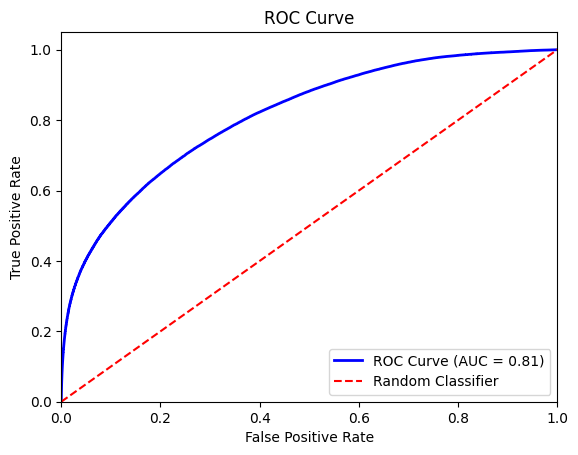

In [ ]:
cat_train, cat_val, feature_importance_df, metrics = cat_cv_model(CatBoostClassifier, x_train, y_train, x_val, "cat")


In [ ]:
cat_auc = roc_auc_score(y_val, cat_val)
print("CatBoost Validation AUC:", cat_auc)


CatBoost Validation AUC: 0.8036688915633473


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np

def cv_model_rf(clf, train_x, train_y, test_x, clf_name, seed=191):
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print("************************************ Fold {} ************************************".format(i+1))

        # Split data into training and validation sets for this fold
        trn_x, trn_y = train_x.iloc[train_index], train_y.iloc[train_index]
        val_x, val_y = train_x.iloc[valid_index], train_y.iloc[valid_index]

        # Set Random Forest parameters
        params = {
            'n_estimators': 300,        # Number of trees
            'max_depth': 10,            # Maximum depth of each tree
            'min_samples_split': 5,     # Minimum samples required to split an internal node
            'min_samples_leaf': 2,      # Minimum samples required to be at a leaf node
            'random_state': seed,       # Random state for reproducibility
            'n_jobs': -1,               # Use all processors
            'bootstrap': True           # Use bootstrapping
        }

        # Initialize and train the RandomForest model
        model = clf(**params)
        model.fit(trn_x, trn_y)

        # Predict probabilities for the validation and test sets
        val_pred = model.predict_proba(val_x)[:, 1]  # Probability of the positive class
        test_pred = model.predict_proba(test_x)[:, 1]

        # Store the validation predictions in the train array
        train[valid_index] = val_pred
        # Average the predictions for the test set across folds
        test += test_pred / kf.n_splits

        # Calculate and store AUC score for this fold
        cv_score = roc_auc_score(val_y, val_pred)
        cv_scores.append(cv_score)

    # Print cross-validation scores
    print(cv_scores)
    print("%s_score_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))

    return train, test

# Example of calling the modified function with RandomForestClassifier
rf_train, rf_val = cv_model_rf(RandomForestClassifier, x_train, y_train, x_val, "rf")


************************************ Fold 1 ************************************
************************************ Fold 2 ************************************
************************************ Fold 3 ************************************
************************************ Fold 4 ************************************
************************************ Fold 5 ************************************
[0.8047978039996693, 0.808936578855278, 0.8088499192958325, 0.8073171316675365, 0.8053586152769009]
rf_score_list: [0.8047978039996693, 0.808936578855278, 0.8088499192958325, 0.8073171316675365, 0.8053586152769009]
rf_score_mean: 0.8070520098190433
rf_score_std: 0.001720662516885226


In [ ]:
rf_auc = roc_auc_score(y_val, rf_val)
print("Random Forest Validation AUC:", rf_auc)

Random Forest Validation AUC: 0.7616243967826569


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np

def cv_model_logistic(clf, train_x, train_y, test_x, clf_name, seed=191):
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print("************************************ Fold {} ************************************".format(i+1))

        # Split data into training and validation sets for this fold
        trn_x, trn_y = train_x.iloc[train_index], train_y.iloc[train_index]
        val_x, val_y = train_x.iloc[valid_index], train_y.iloc[valid_index]

        # Set Logistic Regression parameters
        params = {
            'solver': 'lbfgs',           # Solver for optimization
            'max_iter': 300,             # Maximum number of iterations
            'random_state': seed         # Random state for reproducibility
        }

        # Initialize and train the Logistic Regression model
        model = clf(**params)
        model.fit(trn_x, trn_y)

        # Predict probabilities for the validation and test sets
        val_pred = model.predict_proba(val_x)[:, 1]  # Probability of the positive class
        test_pred = model.predict_proba(test_x)[:, 1]

        # Store the validation predictions in the train array
        train[valid_index] = val_pred
        # Average the predictions for the test set across folds
        test += test_pred / kf.n_splits

        # Calculate and store AUC score for this fold
        cv_score = roc_auc_score(val_y, val_pred)
        cv_scores.append(cv_score)

    # Print cross-validation scores
    print(cv_scores)
    print("%s_score_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))

    return train, test

logistic_train, logistic_val = cv_model_logistic(LogisticRegression, x_train, y_train, x_val, "logistic")


************************************ Fold 1 ************************************
************************************ Fold 2 ************************************
************************************ Fold 3 ************************************
************************************ Fold 4 ************************************
************************************ Fold 5 ************************************
[0.499780267000174, 0.4999662472988997, 0.5003810311437747, 0.5014181510015709, 0.4991250677065001]
logistic_score_list: [0.499780267000174, 0.4999662472988997, 0.5003810311437747, 0.5014181510015709, 0.4991250677065001]
logistic_score_mean: 0.5001341528301839
logistic_score_std: 0.000759115332581849


In [ ]:
logistic_auc = roc_auc_score(y_val, logistic_val)
print("Logistic Validation AUC:", logistic_auc)

Logistic Validation AUC: 0.5004109332374663


### Model Sensitivity


"Is our CatBoost model robust to shifts in the distribution of categorical values within specific features? To what extent would changes in the frequency of certain categories impact the model's accuracy or other performance metrics?"

### Baseline Model - Removed 30% of the training data randomly

In [ ]:
sample_indices1 = x_train.sample(frac=0.7, random_state=101).index
sample_indices2 = x_train.sample(frac=0.7, random_state=121).index
sample_indices3 = x_train.sample(frac=0.7, random_state=152).index
sample_indices4 = x_train.sample(frac=0.7, random_state=11).index
sample_indices5 = x_train.sample(frac=0.7, random_state=127).index

x_train_reduced1 = x_train.loc[sample_indices1]
y_train_reduced1 = y_train.loc[sample_indices1]

x_train_reduced2 = x_train.loc[sample_indices2]
y_train_reduced2 = y_train.loc[sample_indices2]

x_train_reduced3 = x_train.loc[sample_indices3]
y_train_reduced3 = y_train.loc[sample_indices3]

x_train_reduced4 = x_train.loc[sample_indices4]
y_train_reduced4 = y_train.loc[sample_indices4]

x_train_reduced5 = x_train.loc[sample_indices5]
y_train_reduced5 = y_train.loc[sample_indices5]

In [ ]:
cat_train_reduced1, cat_val_reduced1, feature_importance_r1 = cat_cv_model(CatBoostClassifier, x_train_reduced1, y_train_reduced1, x_val, "cat")


************************************ Fold 1 ************************************


0:	test: 0.6804239	best: 0.6804239 (0)	total: 193ms	remaining: 9m 39s
200:	test: 0.8045453	best: 0.8045644 (199)	total: 38.4s	remaining: 8m 54s
400:	test: 0.8070726	best: 0.8070726 (400)	total: 1m 17s	remaining: 8m 21s
600:	test: 0.8079465	best: 0.8079686 (587)	total: 1m 56s	remaining: 7m 44s
800:	test: 0.8086660	best: 0.8086660 (800)	total: 2m 35s	remaining: 7m 7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8089726432
bestIteration = 937

Shrink model to first 938 iterations.
************************************ Fold 2 ************************************


0:	test: 0.6769505	best: 0.6769505 (0)	total: 222ms	remaining: 11m 7s
200:	test: 0.8074460	best: 0.8074460 (200)	total: 38.1s	remaining: 8m 50s
400:	test: 0.8097879	best: 0.8097885 (399)	total: 1m 15s	remaining: 8m 12s
600:	test: 0.8109976	best: 0.8110134 (581)	total: 1m 53s	remaining: 7m 34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8114326657
bestIteration = 746

Shrink model to first 747 iterations.
************************************ Fold 3 ************************************


0:	test: 0.6799918	best: 0.6799918 (0)	total: 195ms	remaining: 9m 43s
200:	test: 0.8045013	best: 0.8045013 (200)	total: 38.3s	remaining: 8m 53s
400:	test: 0.8062458	best: 0.8062629 (390)	total: 1m 16s	remaining: 8m 13s
600:	test: 0.8074462	best: 0.8074469 (596)	total: 1m 53s	remaining: 7m 34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8077493765
bestIteration = 669

Shrink model to first 670 iterations.
************************************ Fold 4 ************************************


0:	test: 0.6837054	best: 0.6837054 (0)	total: 225ms	remaining: 11m 15s
200:	test: 0.8073286	best: 0.8073286 (200)	total: 38s	remaining: 8m 49s
400:	test: 0.8098896	best: 0.8098896 (400)	total: 1m 16s	remaining: 8m 18s
600:	test: 0.8107227	best: 0.8107291 (597)	total: 1m 55s	remaining: 7m 39s
800:	test: 0.8113193	best: 0.8114125 (754)	total: 2m 33s	remaining: 7m
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8114124511
bestIteration = 754

Shrink model to first 755 iterations.
************************************ Fold 5 ************************************


0:	test: 0.5204403	best: 0.5204403 (0)	total: 179ms	remaining: 8m 56s
200:	test: 0.8024876	best: 0.8024876 (200)	total: 38s	remaining: 8m 49s
400:	test: 0.8054536	best: 0.8054590 (399)	total: 1m 15s	remaining: 8m 11s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8060307974
bestIteration = 457

Shrink model to first 458 iterations.
[0.8089726432158334, 0.8114326656808082, 0.8077493764861251, 0.8114124511471672, 0.8060307974065416]
cat_score_list: [0.8089726432158334, 0.8114326656808082, 0.8077493764861251, 0.8114124511471672, 0.8060307974065416]
cat_score_mean: 0.8091195867872951
cat_score_std: 0.002099869017899417
Feature Importances:
                                     mean_importance
creat_type_cd                             45.928514
slot_id                                    9.628511
i_s_sourceId_feeds_nunique                 3.888456
u_refreshTimes                             3.696661
i_dislikeTimes_feeds_nunique               2.659840
i_docId_feeds_nunique 

In [ ]:
cat_train_reduced2, cat_val_reduced2, feature_importance_r2 = cat_cv_model(CatBoostClassifier, x_train_reduced2, y_train_reduced2, x_val, "cat")
cat_train_reduced3, cat_val_reduced3, feature_importance_r3 = cat_cv_model(CatBoostClassifier, x_train_reduced3, y_train_reduced3, x_val, "cat")
cat_train_reduced4, cat_val_reduced4, feature_importance_r4 = cat_cv_model(CatBoostClassifier, x_train_reduced4, y_train_reduced4, x_val, "cat")
cat_train_reduced5, cat_val_reduced5, feature_importance_r5 = cat_cv_model(CatBoostClassifier, x_train_reduced5, y_train_reduced5, x_val, "cat")


************************************ Fold 1 ************************************


0:	test: 0.6818100	best: 0.6818100 (0)	total: 255ms	remaining: 12m 43s
200:	test: 0.8068877	best: 0.8068877 (200)	total: 38.3s	remaining: 8m 53s
400:	test: 0.8091057	best: 0.8091057 (400)	total: 1m 16s	remaining: 8m 13s
600:	test: 0.8100014	best: 0.8100014 (600)	total: 1m 54s	remaining: 7m 35s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8103490366
bestIteration = 674

Shrink model to first 675 iterations.
************************************ Fold 2 ************************************


0:	test: 0.6786773	best: 0.6786773 (0)	total: 202ms	remaining: 10m 5s
200:	test: 0.8057188	best: 0.8057188 (200)	total: 38.1s	remaining: 8m 49s
400:	test: 0.8082241	best: 0.8082524 (395)	total: 1m 15s	remaining: 8m 12s
600:	test: 0.8092667	best: 0.8092667 (600)	total: 1m 53s	remaining: 7m 33s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8100306307
bestIteration = 716

Shrink model to first 717 iterations.
************************************ Fold 3 ************************************


0:	test: 0.6786176	best: 0.6786176 (0)	total: 223ms	remaining: 11m 9s
200:	test: 0.8024524	best: 0.8024649 (199)	total: 38.2s	remaining: 8m 51s
400:	test: 0.8052119	best: 0.8052282 (398)	total: 1m 16s	remaining: 8m 12s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8061873239
bestIteration = 501

Shrink model to first 502 iterations.
************************************ Fold 4 ************************************


0:	test: 0.6793664	best: 0.6793664 (0)	total: 226ms	remaining: 11m 17s
200:	test: 0.8066480	best: 0.8066480 (200)	total: 37.6s	remaining: 8m 43s
400:	test: 0.8094529	best: 0.8094529 (400)	total: 1m 15s	remaining: 8m 6s
600:	test: 0.8108590	best: 0.8109100 (589)	total: 1m 52s	remaining: 7m 29s
800:	test: 0.8116916	best: 0.8116916 (800)	total: 2m 30s	remaining: 6m 51s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8118483281
bestIteration = 870

Shrink model to first 871 iterations.
************************************ Fold 5 ************************************


0:	test: 0.5189259	best: 0.5189259 (0)	total: 183ms	remaining: 9m 7s
200:	test: 0.8042752	best: 0.8042752 (200)	total: 37.7s	remaining: 8m 44s
400:	test: 0.8074700	best: 0.8074966 (398)	total: 1m 14s	remaining: 8m 5s
600:	test: 0.8089054	best: 0.8089054 (600)	total: 1m 52s	remaining: 7m 29s
800:	test: 0.8093928	best: 0.8094719 (758)	total: 2m 30s	remaining: 6m 52s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8094719161
bestIteration = 758

Shrink model to first 759 iterations.
[0.8103490366200838, 0.810030630710145, 0.8061873238558612, 0.8118483280702238, 0.8094719160611663]
cat_score_list: [0.8103490366200838, 0.810030630710145, 0.8061873238558612, 0.8118483280702238, 0.8094719160611663]
cat_score_mean: 0.8095774470634961
cat_score_std: 0.0018687802740578732
Feature Importances:
                                     mean_importance
creat_type_cd                             46.081105
slot_id                                    9.657590
i_s_sourceId_feeds_nunique   

0:	test: 0.6806013	best: 0.6806013 (0)	total: 225ms	remaining: 11m 16s
200:	test: 0.8047048	best: 0.8047048 (200)	total: 38.2s	remaining: 8m 51s
400:	test: 0.8070822	best: 0.8070822 (400)	total: 1m 15s	remaining: 8m 11s
600:	test: 0.8082622	best: 0.8082622 (600)	total: 1m 54s	remaining: 7m 36s
800:	test: 0.8090165	best: 0.8090296 (798)	total: 2m 32s	remaining: 6m 57s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8094619474
bestIteration = 933

Shrink model to first 934 iterations.
************************************ Fold 2 ************************************


0:	test: 0.6815536	best: 0.6815536 (0)	total: 194ms	remaining: 9m 40s
200:	test: 0.8064561	best: 0.8064561 (200)	total: 37.3s	remaining: 8m 39s
400:	test: 0.8087556	best: 0.8087663 (398)	total: 1m 14s	remaining: 8m 4s
600:	test: 0.8099886	best: 0.8099886 (600)	total: 1m 52s	remaining: 7m 27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8102115806
bestIteration = 682

Shrink model to first 683 iterations.
************************************ Fold 3 ************************************


0:	test: 0.6827503	best: 0.6827503 (0)	total: 189ms	remaining: 9m 25s
200:	test: 0.8051240	best: 0.8051240 (200)	total: 38.2s	remaining: 8m 51s
400:	test: 0.8079602	best: 0.8080590 (393)	total: 1m 15s	remaining: 8m 11s
600:	test: 0.8087525	best: 0.8088061 (570)	total: 1m 53s	remaining: 7m 32s
800:	test: 0.8091719	best: 0.8092156 (792)	total: 2m 30s	remaining: 6m 53s
1000:	test: 0.8098343	best: 0.8098348 (999)	total: 3m 8s	remaining: 6m 15s
1200:	test: 0.8101120	best: 0.8101352 (1198)	total: 3m 45s	remaining: 5m 38s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8101351593
bestIteration = 1198

Shrink model to first 1199 iterations.
************************************ Fold 4 ************************************


0:	test: 0.6809145	best: 0.6809145 (0)	total: 195ms	remaining: 9m 45s
200:	test: 0.8085102	best: 0.8085102 (200)	total: 38.5s	remaining: 8m 55s
400:	test: 0.8116148	best: 0.8116148 (400)	total: 1m 16s	remaining: 8m 13s
600:	test: 0.8122976	best: 0.8123389 (551)	total: 1m 53s	remaining: 7m 34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8123389024
bestIteration = 551

Shrink model to first 552 iterations.
************************************ Fold 5 ************************************


0:	test: 0.5201699	best: 0.5201699 (0)	total: 190ms	remaining: 9m 29s
200:	test: 0.8049093	best: 0.8049218 (196)	total: 37.8s	remaining: 8m 46s
400:	test: 0.8070960	best: 0.8071045 (398)	total: 1m 15s	remaining: 8m 7s
600:	test: 0.8082512	best: 0.8082512 (600)	total: 1m 52s	remaining: 7m 30s
800:	test: 0.8087491	best: 0.8087972 (790)	total: 2m 30s	remaining: 6m 53s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8091599876
bestIteration = 917

Shrink model to first 918 iterations.
[0.8094619474114005, 0.8102115806144137, 0.8101351593237356, 0.8123389024202018, 0.8091599875831895]
cat_score_list: [0.8094619474114005, 0.8102115806144137, 0.8101351593237356, 0.8123389024202018, 0.8091599875831895]
cat_score_mean: 0.8102615154705882
cat_score_std: 0.0011123550397353886
Feature Importances:
                                     mean_importance
creat_type_cd                             44.624624
slot_id                                    9.653510
i_s_sourceId_feeds_nunique

0:	test: 0.6787916	best: 0.6787916 (0)	total: 192ms	remaining: 9m 37s
200:	test: 0.8029236	best: 0.8029236 (200)	total: 38s	remaining: 8m 49s
400:	test: 0.8064918	best: 0.8064918 (400)	total: 1m 15s	remaining: 8m 9s
600:	test: 0.8073294	best: 0.8073992 (582)	total: 1m 53s	remaining: 7m 31s
800:	test: 0.8078740	best: 0.8078740 (800)	total: 2m 30s	remaining: 6m 53s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8079234151
bestIteration = 812

Shrink model to first 813 iterations.
************************************ Fold 2 ************************************


0:	test: 0.6813109	best: 0.6813109 (0)	total: 190ms	remaining: 9m 30s
200:	test: 0.8084685	best: 0.8084689 (199)	total: 38.5s	remaining: 8m 55s
400:	test: 0.8101744	best: 0.8101744 (400)	total: 1m 16s	remaining: 8m 14s
600:	test: 0.8114126	best: 0.8114161 (599)	total: 1m 53s	remaining: 7m 34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8121559472
bestIteration = 745

Shrink model to first 746 iterations.
************************************ Fold 3 ************************************


0:	test: 0.6809894	best: 0.6809894 (0)	total: 192ms	remaining: 9m 34s
200:	test: 0.7994343	best: 0.7994498 (199)	total: 37.9s	remaining: 8m 47s
400:	test: 0.8022102	best: 0.8022102 (400)	total: 1m 15s	remaining: 8m 6s
600:	test: 0.8035236	best: 0.8035327 (596)	total: 1m 52s	remaining: 7m 28s
800:	test: 0.8040435	best: 0.8040694 (796)	total: 2m 30s	remaining: 6m 52s
1000:	test: 0.8050237	best: 0.8050323 (998)	total: 3m 7s	remaining: 6m 15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8050982649
bestIteration = 1010

Shrink model to first 1011 iterations.
************************************ Fold 4 ************************************


0:	test: 0.6815557	best: 0.6815557 (0)	total: 194ms	remaining: 9m 42s
200:	test: 0.8081255	best: 0.8081255 (200)	total: 38.2s	remaining: 8m 52s
400:	test: 0.8106258	best: 0.8106258 (400)	total: 1m 16s	remaining: 8m 13s
600:	test: 0.8116838	best: 0.8116838 (600)	total: 1m 53s	remaining: 7m 33s
800:	test: 0.8126645	best: 0.8126645 (800)	total: 2m 31s	remaining: 6m 54s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8128382164
bestIteration = 875

Shrink model to first 876 iterations.
************************************ Fold 5 ************************************


0:	test: 0.5257518	best: 0.5257518 (0)	total: 217ms	remaining: 10m 50s
200:	test: 0.8063856	best: 0.8063856 (200)	total: 38s	remaining: 8m 49s
400:	test: 0.8088617	best: 0.8088617 (400)	total: 1m 15s	remaining: 8m 8s
600:	test: 0.8102280	best: 0.8102506 (595)	total: 1m 52s	remaining: 7m 29s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8104826269
bestIteration = 665

Shrink model to first 666 iterations.
[0.8079234150909762, 0.8121559472246458, 0.8050982648665626, 0.8128382164005171, 0.8104826268862246]
cat_score_list: [0.8079234150909762, 0.8121559472246458, 0.8050982648665626, 0.8128382164005171, 0.8104826268862246]
cat_score_mean: 0.8096996940937853
cat_score_std: 0.0028574395356385854
Feature Importances:
                                     mean_importance
creat_type_cd                             45.489768
slot_id                                    9.754906
i_s_sourceId_feeds_nunique                 4.085658
u_refreshTimes                             3.50886

0:	test: 0.6775927	best: 0.6775927 (0)	total: 193ms	remaining: 9m 39s
200:	test: 0.8026039	best: 0.8026039 (200)	total: 38.4s	remaining: 8m 54s
400:	test: 0.8055981	best: 0.8056162 (397)	total: 1m 16s	remaining: 8m 12s
600:	test: 0.8067211	best: 0.8067392 (597)	total: 1m 54s	remaining: 7m 35s
800:	test: 0.8071281	best: 0.8071332 (798)	total: 2m 31s	remaining: 6m 57s
1000:	test: 0.8076452	best: 0.8076685 (996)	total: 3m 9s	remaining: 6m 18s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8076761525
bestIteration = 1018

Shrink model to first 1019 iterations.
************************************ Fold 2 ************************************


0:	test: 0.6823131	best: 0.6823131 (0)	total: 190ms	remaining: 9m 30s
200:	test: 0.8069095	best: 0.8069095 (200)	total: 38.2s	remaining: 8m 51s
400:	test: 0.8087795	best: 0.8088112 (397)	total: 1m 15s	remaining: 8m 11s
600:	test: 0.8098937	best: 0.8098937 (600)	total: 1m 53s	remaining: 7m 31s
800:	test: 0.8109053	best: 0.8109570 (794)	total: 2m 31s	remaining: 6m 55s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8111554267
bestIteration = 877

Shrink model to first 878 iterations.
************************************ Fold 3 ************************************


0:	test: 0.6818033	best: 0.6818033 (0)	total: 192ms	remaining: 9m 35s
200:	test: 0.8047797	best: 0.8047893 (198)	total: 37.8s	remaining: 8m 45s
400:	test: 0.8079041	best: 0.8079041 (400)	total: 1m 15s	remaining: 8m 6s
600:	test: 0.8091914	best: 0.8092001 (599)	total: 1m 52s	remaining: 7m 30s
800:	test: 0.8098052	best: 0.8099440 (772)	total: 2m 30s	remaining: 6m 54s
1000:	test: 0.8105146	best: 0.8105146 (1000)	total: 3m 9s	remaining: 6m 17s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8105986246
bestIteration = 1023

Shrink model to first 1024 iterations.
************************************ Fold 4 ************************************


0:	test: 0.6773618	best: 0.6773618 (0)	total: 191ms	remaining: 9m 31s
200:	test: 0.8058575	best: 0.8058575 (200)	total: 38.2s	remaining: 8m 52s
400:	test: 0.8083606	best: 0.8083644 (399)	total: 1m 16s	remaining: 8m 13s
600:	test: 0.8094513	best: 0.8094513 (600)	total: 1m 53s	remaining: 7m 34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8095070498
bestIteration = 607

Shrink model to first 608 iterations.
************************************ Fold 5 ************************************


0:	test: 0.5194953	best: 0.5194953 (0)	total: 181ms	remaining: 9m 1s
200:	test: 0.8075164	best: 0.8075164 (200)	total: 38.2s	remaining: 8m 52s
400:	test: 0.8103628	best: 0.8103628 (400)	total: 1m 15s	remaining: 8m 10s
600:	test: 0.8114965	best: 0.8115296 (597)	total: 1m 53s	remaining: 7m 34s
800:	test: 0.8119524	best: 0.8119524 (800)	total: 2m 31s	remaining: 6m 56s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8121114631
bestIteration = 839

Shrink model to first 840 iterations.
[0.8076761524771736, 0.8111554267467619, 0.8105986245815119, 0.8095070497927477, 0.8121114630547773]
cat_score_list: [0.8076761524771736, 0.8111554267467619, 0.8105986245815119, 0.8095070497927477, 0.8121114630547773]
cat_score_mean: 0.8102097433305945
cat_score_std: 0.001521508756527201
Feature Importances:
                                     mean_importance
creat_type_cd                             44.142468
slot_id                                    9.700358
i_s_sourceId_feeds_nunique 

In [ ]:
cat_auc_r = roc_auc_score(y_val, cat_val_reduced5)
print("CatBoost Validation AUC:", cat_auc_r)

CatBoost Validation AUC: 0.8014297173756255


### Modified Model - with selected feature having certain categories removed

In [ ]:
x_train['creat_type_cd'].value_counts(normalize=True) * 100

,proportion
creat_type_cd,
8,52.669210
10,28.378091
5,6.134799
3,4.627718
7,4.335099
2,2.401565
4,0.885559
6,0.378378
9,0.189580


In [ ]:
x_train['slot_id'].value_counts(normalize=True) * 100

,proportion
slot_id,
16,24.638196
17,6.366266
54,5.847147
38,5.068372
50,4.832281
59,4.624363
22,4.577624
35,3.823847
13,3.718708


In [ ]:
x_train['i_upTimes_feeds_nunique'].value_counts(normalize=True) * 100

,proportion
i_upTimes_feeds_nunique,
10,61.150626
9,13.867227
8,7.106835
7,4.487825
6,3.420877
5,2.608000
4,2.069177
3,1.859093
1,1.725763


In [ ]:
import pandas as pd

# Define the columns you want to process
columns_to_process = [
    'creat_type_cd', 'slot_id', 'u_refreshTimes', 'i_dislikeTimes_feeds_nunique',
    'i_docId_feeds_nunique', 'u_newsCatInterestsST_feeds_nunique', 'i_cat_feeds_nunique',
    'i_upTimes_feeds_nunique', 'i_entities_feeds_nunique', 'task_id', 'adv_prim_id',
    'age', 'e_et_feeds_nunique', 'adv_id', 'hispace_app_tags'
]

# Calculate the number of rows to remove based on the original x_train_reduced
num_rows_to_remove = x_train.shape[0] - x_train_reduced1.shape[0]

# Iterate over each column to create unique modified datasets
for idx, col in enumerate(columns_to_process, start=1):
    # Start from the original x_train and y_train for each column
    x_train_copy = x_train.copy()
    y_train_copy = y_train.copy()

    print(f"Processing column: {col}")

    # Step 1: Find the top 3 categories and their combined row count
    top_3_categories = x_train_copy[col].value_counts().nlargest(3)
    top_3_total_rows = top_3_categories.sum()

    # Step 2: Check if top 3 categories have enough rows to meet num_rows_to_remove
    if top_3_total_rows >= num_rows_to_remove:
        # Sample rows only from the top 3 categories
        rows_to_remove = x_train_copy[x_train_copy[col].isin(top_3_categories.index)].sample(
            n=num_rows_to_remove, random_state=42
        ).index
        print(f"Dropping {num_rows_to_remove} rows from the top 3 categories in column {col}.")
    else:
        # Sample rows from all categories
        rows_to_remove = x_train_copy.sample(n=num_rows_to_remove, random_state=42).index
        print(f"Dropping {num_rows_to_remove} rows from all categories in column {col}.")

    # Step 3: Drop the sampled rows
    x_train_copy = x_train_copy.drop(rows_to_remove)
    y_train_copy = y_train_copy.drop(rows_to_remove)

    # Step 4: Store the modified versions as separate variables with unique names
    globals()[f'x_train_mod{idx}'] = x_train_copy
    globals()[f'y_train_mod{idx}'] = y_train_copy

    # Print out the shape of the new modified data for verification
    print(f"x_train_mod{idx} shape: {x_train_copy.shape}")
    print(f"y_train_mod{idx} shape: {y_train_copy.shape}\n")

# Example: Accessing the created variables directly
# x_train_mod1, y_train_mod1, x_train_mod2, y_train_mod2, etc.


Processing column: creat_type_cd
Dropping 1842124 rows from the top 3 categories in column creat_type_cd.
x_train_mod1 shape: (4298289, 59)
y_train_mod1 shape: (4298289,)

Processing column: slot_id
Dropping 1842124 rows from the top 3 categories in column slot_id.
x_train_mod2 shape: (4298289, 59)
y_train_mod2 shape: (4298289,)

Processing column: u_refreshTimes
Dropping 1842124 rows from the top 3 categories in column u_refreshTimes.
x_train_mod3 shape: (4298289, 59)
y_train_mod3 shape: (4298289,)

Processing column: i_dislikeTimes_feeds_nunique
Dropping 1842124 rows from the top 3 categories in column i_dislikeTimes_feeds_nunique.
x_train_mod4 shape: (4298289, 59)
y_train_mod4 shape: (4298289,)

Processing column: i_docId_feeds_nunique
Dropping 1842124 rows from all categories in column i_docId_feeds_nunique.
x_train_mod5 shape: (4298289, 59)
y_train_mod5 shape: (4298289,)

Processing column: u_newsCatInterestsST_feeds_nunique
Dropping 1842124 rows from all categories in column u_ne

In [ ]:
cat_train_mod1, cat_val_mod1, feature_importance_m1 = cat_cv_model(CatBoostClassifier, x_train_mod1, y_train_mod1, x_val, "cat")


************************************ Fold 1 ************************************


0:	test: 0.6725091	best: 0.6725091 (0)	total: 274ms	remaining: 13m 40s
200:	test: 0.8000292	best: 0.8000292 (200)	total: 44.3s	remaining: 10m 17s
400:	test: 0.8032441	best: 0.8032441 (400)	total: 1m 26s	remaining: 9m 21s
600:	test: 0.8046342	best: 0.8046412 (599)	total: 2m 5s	remaining: 8m 22s
800:	test: 0.8051321	best: 0.8051675 (758)	total: 2m 45s	remaining: 7m 34s
1000:	test: 0.8057221	best: 0.8058035 (956)	total: 3m 24s	remaining: 6m 49s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8058035352
bestIteration = 956

Shrink model to first 957 iterations.
************************************ Fold 2 ************************************


0:	test: 0.6742089	best: 0.6742089 (0)	total: 209ms	remaining: 10m 28s
200:	test: 0.8038502	best: 0.8038569 (196)	total: 39.9s	remaining: 9m 15s
400:	test: 0.8065748	best: 0.8066109 (394)	total: 1m 19s	remaining: 8m 35s
600:	test: 0.8081068	best: 0.8081398 (590)	total: 1m 58s	remaining: 7m 54s
800:	test: 0.8087837	best: 0.8088152 (793)	total: 2m 37s	remaining: 7m 13s
1000:	test: 0.8095943	best: 0.8096160 (980)	total: 3m 17s	remaining: 6m 34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8096160361
bestIteration = 980

Shrink model to first 981 iterations.
************************************ Fold 3 ************************************


0:	test: 0.6708241	best: 0.6708241 (0)	total: 206ms	remaining: 10m 16s
200:	test: 0.8018057	best: 0.8018057 (200)	total: 40s	remaining: 9m 16s
400:	test: 0.8043267	best: 0.8043267 (400)	total: 1m 19s	remaining: 8m 33s
600:	test: 0.8052511	best: 0.8052795 (567)	total: 1m 59s	remaining: 7m 55s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8053999746
bestIteration = 623

Shrink model to first 624 iterations.
************************************ Fold 4 ************************************


0:	test: 0.6719154	best: 0.6719154 (0)	total: 235ms	remaining: 11m 45s
200:	test: 0.8004514	best: 0.8004514 (200)	total: 39.8s	remaining: 9m 14s
400:	test: 0.8037459	best: 0.8037459 (400)	total: 1m 19s	remaining: 8m 32s
600:	test: 0.8050424	best: 0.8050424 (600)	total: 1m 58s	remaining: 7m 53s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.805569652
bestIteration = 732

Shrink model to first 733 iterations.
************************************ Fold 5 ************************************


0:	test: 0.5275336	best: 0.5275336 (0)	total: 199ms	remaining: 9m 57s
200:	test: 0.8071163	best: 0.8071163 (200)	total: 40.6s	remaining: 9m 25s
400:	test: 0.8091190	best: 0.8091701 (393)	total: 1m 20s	remaining: 8m 39s
600:	test: 0.8098902	best: 0.8099685 (589)	total: 1m 59s	remaining: 7m 58s
800:	test: 0.8103324	best: 0.8104538 (770)	total: 2m 39s	remaining: 7m 17s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8104537728
bestIteration = 770

Shrink model to first 771 iterations.
[0.8058035351511957, 0.8096160360866232, 0.8053999746100872, 0.8055696519922639, 0.8104537728193599]
cat_score_list: [0.8058035351511957, 0.8096160360866232, 0.8053999746100872, 0.8055696519922639, 0.8104537728193599]
cat_score_mean: 0.807368594131906
cat_score_std: 0.0021968335453516393
Feature Importances:
                                     mean_importance
creat_type_cd                             44.245062
slot_id                                    9.821405
i_docId_feeds_nunique     

In [ ]:
#cat_train_mod2, cat_val_mod2, feature_importance_m2 = cat_cv_model(CatBoostClassifier, x_train_mod2, y_train_mod2, x_val, "cat")


cat_train_mod7, cat_val_mod7, feature_importance_m7 = cat_cv_model(CatBoostClassifier, x_train_mod7, y_train_mod7, x_val, "cat")
cat_train_mod8, cat_val_mod8, feature_importance_m8 = cat_cv_model(CatBoostClassifier, x_train_mod8, y_train_mod8, x_val, "cat")
cat_train_mod9, cat_val_mod9, feature_importance_m9 = cat_cv_model(CatBoostClassifier, x_train_mod9, y_train_mod9, x_val, "cat")


************************************ Fold 1 ************************************


KeyboardInterrupt: 

Exception ignored in: '_catboost._WriteLog'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/iostream.py", line 384, in write
    def write(self, string):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
cat_train_mod3, cat_val_mod3, feature_importance_m3 = cat_cv_model(CatBoostClassifier, x_train_mod3, y_train_mod3, x_val, "cat")
cat_train_mod4, cat_val_mod4, feature_importance_m4 = cat_cv_model(CatBoostClassifier, x_train_mod4, y_train_mod4, x_val, "cat")

************************************ Fold 1 ************************************


0:	test: 0.6576866	best: 0.6576866 (0)	total: 237ms	remaining: 11m 51s
200:	test: 0.7820458	best: 0.7820458 (200)	total: 40.2s	remaining: 9m 20s
400:	test: 0.7853482	best: 0.7853482 (400)	total: 1m 20s	remaining: 8m 38s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7863699474
bestIteration = 531

Shrink model to first 532 iterations.
************************************ Fold 2 ************************************


0:	test: 0.6595949	best: 0.6595949 (0)	total: 240ms	remaining: 12m
200:	test: 0.7839324	best: 0.7839324 (200)	total: 39.8s	remaining: 9m 14s
400:	test: 0.7869382	best: 0.7869601 (399)	total: 1m 19s	remaining: 8m 35s
600:	test: 0.7880798	best: 0.7881057 (598)	total: 1m 59s	remaining: 7m 55s
800:	test: 0.7887150	best: 0.7887479 (781)	total: 2m 38s	remaining: 7m 15s
1000:	test: 0.7889922	best: 0.7890982 (984)	total: 3m 18s	remaining: 6m 35s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7890982049
bestIteration = 984

Shrink model to first 985 iterations.
************************************ Fold 3 ************************************


0:	test: 0.6591843	best: 0.6591843 (0)	total: 210ms	remaining: 10m 30s
200:	test: 0.7848199	best: 0.7848199 (200)	total: 40.4s	remaining: 9m 22s
400:	test: 0.7873148	best: 0.7873148 (400)	total: 1m 20s	remaining: 8m 38s
600:	test: 0.7889338	best: 0.7889338 (600)	total: 1m 59s	remaining: 7m 58s
800:	test: 0.7897418	best: 0.7897418 (800)	total: 2m 39s	remaining: 7m 17s
1000:	test: 0.7902540	best: 0.7902540 (1000)	total: 3m 19s	remaining: 6m 38s
1200:	test: 0.7906718	best: 0.7907533 (1172)	total: 3m 59s	remaining: 5m 58s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7907533305
bestIteration = 1172

Shrink model to first 1173 iterations.
************************************ Fold 4 ************************************


0:	test: 0.6604864	best: 0.6604864 (0)	total: 233ms	remaining: 11m 38s
200:	test: 0.7873321	best: 0.7873321 (200)	total: 40.1s	remaining: 9m 18s
400:	test: 0.7900554	best: 0.7900562 (398)	total: 1m 19s	remaining: 8m 36s
600:	test: 0.7911274	best: 0.7911274 (600)	total: 1m 58s	remaining: 7m 54s
800:	test: 0.7920245	best: 0.7921111 (777)	total: 2m 38s	remaining: 7m 14s
1000:	test: 0.7926879	best: 0.7926879 (1000)	total: 3m 18s	remaining: 6m 36s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7930656652
bestIteration = 1127

Shrink model to first 1128 iterations.
************************************ Fold 5 ************************************


0:	test: 0.5165734	best: 0.5165734 (0)	total: 191ms	remaining: 9m 33s
200:	test: 0.7851643	best: 0.7851643 (200)	total: 40.3s	remaining: 9m 21s
400:	test: 0.7877745	best: 0.7878303 (379)	total: 1m 19s	remaining: 8m 38s
600:	test: 0.7889209	best: 0.7889701 (579)	total: 1m 59s	remaining: 7m 58s
800:	test: 0.7896166	best: 0.7896579 (788)	total: 2m 39s	remaining: 7m 18s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7896985826
bestIteration = 824

Shrink model to first 825 iterations.
[0.7863699474366558, 0.7890982048868362, 0.7907533304993221, 0.7930656651631199, 0.7896985826066771]
cat_score_list: [0.7863699474366558, 0.7890982048868362, 0.7907533304993221, 0.7930656651631199, 0.7896985826066771]
cat_score_mean: 0.7897971461185223
cat_score_std: 0.0021836405258736412
Feature Importances:
                                     mean_importance
creat_type_cd                             43.845540
slot_id                                    9.945569
u_refreshTimes           

0:	test: 0.6907570	best: 0.6907570 (0)	total: 239ms	remaining: 11m 56s
200:	test: 0.8200514	best: 0.8200514 (200)	total: 40.2s	remaining: 9m 19s
400:	test: 0.8222356	best: 0.8222356 (400)	total: 1m 19s	remaining: 8m 36s
600:	test: 0.8231537	best: 0.8231742 (596)	total: 1m 59s	remaining: 7m 55s
800:	test: 0.8240591	best: 0.8240606 (799)	total: 2m 39s	remaining: 7m 16s
1000:	test: 0.8243381	best: 0.8244130 (975)	total: 3m 18s	remaining: 6m 36s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8244129599
bestIteration = 975

Shrink model to first 976 iterations.
************************************ Fold 2 ************************************


0:	test: 0.6919218	best: 0.6919218 (0)	total: 207ms	remaining: 10m 19s
200:	test: 0.8175904	best: 0.8175982 (199)	total: 40.1s	remaining: 9m 18s
400:	test: 0.8205640	best: 0.8205640 (400)	total: 1m 19s	remaining: 8m 37s
600:	test: 0.8212781	best: 0.8212781 (600)	total: 1m 59s	remaining: 7m 56s
800:	test: 0.8219039	best: 0.8219396 (774)	total: 2m 39s	remaining: 7m 17s
1000:	test: 0.8225256	best: 0.8226299 (967)	total: 3m 19s	remaining: 6m 38s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.822629897
bestIteration = 967

Shrink model to first 968 iterations.
************************************ Fold 3 ************************************


0:	test: 0.6960642	best: 0.6960642 (0)	total: 201ms	remaining: 10m 2s
200:	test: 0.8227489	best: 0.8227489 (200)	total: 40s	remaining: 9m 16s
400:	test: 0.8253197	best: 0.8253373 (394)	total: 1m 19s	remaining: 8m 36s
600:	test: 0.8264361	best: 0.8264361 (600)	total: 1m 59s	remaining: 7m 56s
800:	test: 0.8268115	best: 0.8268637 (771)	total: 2m 39s	remaining: 7m 17s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8269989987
bestIteration = 906

Shrink model to first 907 iterations.
************************************ Fold 4 ************************************


0:	test: 0.6920175	best: 0.6920175 (0)	total: 206ms	remaining: 10m 18s
200:	test: 0.8205059	best: 0.8205059 (200)	total: 39.8s	remaining: 9m 14s
400:	test: 0.8229104	best: 0.8229191 (382)	total: 1m 18s	remaining: 8m 31s
600:	test: 0.8238177	best: 0.8238177 (600)	total: 1m 58s	remaining: 7m 52s
800:	test: 0.8244391	best: 0.8244439 (799)	total: 2m 38s	remaining: 7m 14s
1000:	test: 0.8251745	best: 0.8251745 (1000)	total: 3m 17s	remaining: 6m 34s
1200:	test: 0.8253773	best: 0.8254278 (1182)	total: 3m 57s	remaining: 5m 55s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8254278244
bestIteration = 1182

Shrink model to first 1183 iterations.
************************************ Fold 5 ************************************


0:	test: 0.6059655	best: 0.6059655 (0)	total: 187ms	remaining: 9m 20s
200:	test: 0.8218318	best: 0.8218318 (200)	total: 40s	remaining: 9m 17s
400:	test: 0.8239686	best: 0.8239787 (398)	total: 1m 19s	remaining: 8m 34s
600:	test: 0.8250723	best: 0.8250723 (600)	total: 1m 59s	remaining: 7m 55s
800:	test: 0.8254961	best: 0.8255539 (781)	total: 2m 38s	remaining: 7m 15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8255538633
bestIteration = 781

Shrink model to first 782 iterations.
[0.8244129598500265, 0.8226298969796736, 0.826998998672138, 0.8254278243848591, 0.825553863268721]
cat_score_list: [0.8244129598500265, 0.8226298969796736, 0.826998998672138, 0.8254278243848591, 0.825553863268721]
cat_score_mean: 0.8250047086310837
cat_score_std: 0.0014455232633573036
Feature Importances:
                                     mean_importance
creat_type_cd                             43.719880
slot_id                                    8.596987
i_s_sourceId_feeds_nunique     

In [ ]:
cat_auc_m = roc_auc_score(y_val, cat_val_mod8)
print("CatBoost Validation AUC:", cat_auc_m)

CatBoost Validation AUC: 0.802179181255195


In [ ]:
cat_train_mod5, cat_val_mod5, feature_importance_m5 = cat_cv_model(CatBoostClassifier, x_train_mod5, y_train_mod5, x_val, "cat")
cat_train_mod6, cat_val_mod6, feature_importance_m6 = cat_cv_model(CatBoostClassifier, x_train_mod6, y_train_mod6, x_val, "cat")

************************************ Fold 1 ************************************


0:	test: 0.6752032	best: 0.6752032 (0)	total: 202ms	remaining: 10m 5s
200:	test: 0.8026341	best: 0.8026341 (200)	total: 40.3s	remaining: 9m 20s
400:	test: 0.8046010	best: 0.8046010 (400)	total: 1m 20s	remaining: 8m 41s
600:	test: 0.8063164	best: 0.8063349 (584)	total: 2m	remaining: 8m
800:	test: 0.8067540	best: 0.8067540 (800)	total: 2m 40s	remaining: 7m 19s
1000:	test: 0.8071422	best: 0.8072256 (982)	total: 3m 19s	remaining: 6m 38s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8072470453
bestIteration = 1030

Shrink model to first 1031 iterations.
************************************ Fold 2 ************************************


0:	test: 0.6812684	best: 0.6812684 (0)	total: 245ms	remaining: 12m 13s
200:	test: 0.8063160	best: 0.8063160 (200)	total: 40s	remaining: 9m 16s
400:	test: 0.8079526	best: 0.8079526 (400)	total: 1m 19s	remaining: 8m 35s
600:	test: 0.8087055	best: 0.8087588 (586)	total: 1m 58s	remaining: 7m 54s
800:	test: 0.8098988	best: 0.8099230 (781)	total: 2m 38s	remaining: 7m 16s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.810113161
bestIteration = 897

Shrink model to first 898 iterations.
************************************ Fold 3 ************************************


0:	test: 0.6799965	best: 0.6799965 (0)	total: 201ms	remaining: 10m 2s
200:	test: 0.8095452	best: 0.8096034 (192)	total: 39.9s	remaining: 9m 16s
400:	test: 0.8127327	best: 0.8127714 (399)	total: 1m 19s	remaining: 8m 36s
600:	test: 0.8137432	best: 0.8137689 (593)	total: 1m 59s	remaining: 7m 56s
800:	test: 0.8144936	best: 0.8145194 (798)	total: 2m 39s	remaining: 7m 17s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8145747637
bestIteration = 845

Shrink model to first 846 iterations.
************************************ Fold 4 ************************************


0:	test: 0.6780303	best: 0.6780303 (0)	total: 242ms	remaining: 12m 6s
200:	test: 0.8060981	best: 0.8060981 (200)	total: 39.8s	remaining: 9m 13s
400:	test: 0.8089319	best: 0.8089319 (400)	total: 1m 19s	remaining: 8m 34s
600:	test: 0.8101808	best: 0.8101808 (600)	total: 1m 58s	remaining: 7m 54s
800:	test: 0.8113020	best: 0.8113392 (795)	total: 2m 38s	remaining: 7m 16s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8113392332
bestIteration = 795

Shrink model to first 796 iterations.
************************************ Fold 5 ************************************


0:	test: 0.5218850	best: 0.5218850 (0)	total: 192ms	remaining: 9m 37s
200:	test: 0.8028703	best: 0.8028703 (200)	total: 39.9s	remaining: 9m 16s
400:	test: 0.8060336	best: 0.8060708 (398)	total: 1m 19s	remaining: 8m 34s
600:	test: 0.8073467	best: 0.8073541 (598)	total: 1m 58s	remaining: 7m 54s
800:	test: 0.8080648	best: 0.8081137 (775)	total: 2m 38s	remaining: 7m 16s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8081137369
bestIteration = 775

Shrink model to first 776 iterations.
[0.8072470452610524, 0.8101131609512324, 0.8145747637325269, 0.8113392332096675, 0.8081137369083568]
cat_score_list: [0.8072470452610524, 0.8101131609512324, 0.8145747637325269, 0.8113392332096675, 0.8081137369083568]
cat_score_mean: 0.8102775880125671
cat_score_std: 0.0025879059844278827
Feature Importances:
                                     mean_importance
creat_type_cd                             44.997315
slot_id                                    9.884868
i_docId_feeds_nunique    

0:	test: 0.6752032	best: 0.6752032 (0)	total: 199ms	remaining: 9m 58s
200:	test: 0.8026341	best: 0.8026341 (200)	total: 39.8s	remaining: 9m 14s
400:	test: 0.8046010	best: 0.8046010 (400)	total: 1m 19s	remaining: 8m 35s
600:	test: 0.8063164	best: 0.8063349 (584)	total: 1m 59s	remaining: 7m 56s
800:	test: 0.8067540	best: 0.8067540 (800)	total: 2m 39s	remaining: 7m 17s
1000:	test: 0.8071422	best: 0.8072256 (982)	total: 3m 19s	remaining: 6m 37s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8072470453
bestIteration = 1030

Shrink model to first 1031 iterations.
************************************ Fold 2 ************************************


0:	test: 0.6812684	best: 0.6812684 (0)	total: 207ms	remaining: 10m 19s
200:	test: 0.8063160	best: 0.8063160 (200)	total: 40s	remaining: 9m 16s
400:	test: 0.8079526	best: 0.8079526 (400)	total: 1m 19s	remaining: 8m 36s
600:	test: 0.8087055	best: 0.8087588 (586)	total: 1m 59s	remaining: 7m 56s
800:	test: 0.8098988	best: 0.8099230 (781)	total: 2m 39s	remaining: 7m 17s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.810113161
bestIteration = 897

Shrink model to first 898 iterations.
************************************ Fold 3 ************************************


0:	test: 0.6799965	best: 0.6799965 (0)	total: 241ms	remaining: 12m 1s
200:	test: 0.8095452	best: 0.8096034 (192)	total: 40s	remaining: 9m 16s
400:	test: 0.8127327	best: 0.8127714 (399)	total: 1m 20s	remaining: 8m 39s
600:	test: 0.8137432	best: 0.8137689 (593)	total: 1m 59s	remaining: 7m 57s
800:	test: 0.8144936	best: 0.8145194 (798)	total: 2m 38s	remaining: 7m 16s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8145747637
bestIteration = 845

Shrink model to first 846 iterations.
************************************ Fold 4 ************************************


0:	test: 0.6780303	best: 0.6780303 (0)	total: 208ms	remaining: 10m 22s
200:	test: 0.8060981	best: 0.8060981 (200)	total: 40s	remaining: 9m 16s
400:	test: 0.8089319	best: 0.8089319 (400)	total: 1m 20s	remaining: 8m 40s
600:	test: 0.8101808	best: 0.8101808 (600)	total: 2m	remaining: 7m 59s
800:	test: 0.8113020	best: 0.8113392 (795)	total: 2m 39s	remaining: 7m 19s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8113392332
bestIteration = 795

Shrink model to first 796 iterations.
************************************ Fold 5 ************************************


0:	test: 0.5218850	best: 0.5218850 (0)	total: 193ms	remaining: 9m 38s
200:	test: 0.8028703	best: 0.8028703 (200)	total: 39.9s	remaining: 9m 15s
400:	test: 0.8060336	best: 0.8060708 (398)	total: 1m 19s	remaining: 8m 37s
600:	test: 0.8073467	best: 0.8073541 (598)	total: 1m 59s	remaining: 7m 56s
800:	test: 0.8080648	best: 0.8081137 (775)	total: 2m 38s	remaining: 7m 15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8081137369
bestIteration = 775

Shrink model to first 776 iterations.
[0.8072470452610524, 0.8101131609512324, 0.8145747637325269, 0.8113392332096675, 0.8081137369083568]
cat_score_list: [0.8072470452610524, 0.8101131609512324, 0.8145747637325269, 0.8113392332096675, 0.8081137369083568]
cat_score_mean: 0.8102775880125671
cat_score_std: 0.0025879059844278827
Feature Importances:
                                     mean_importance
creat_type_cd                             44.997315
slot_id                                    9.884868
i_docId_feeds_nunique    

In [ ]:
cat_val_mod8

array([0.00931235, 0.00743572, 0.00092228, ..., 0.01133263, 0.0239551 ,
       0.01394619])

In [ ]:
cat_train_mod7, cat_val_mod7, feature_importance_m7 = cat_cv_model(CatBoostClassifier, x_train_mod7, y_train_mod7, x_val, "cat")
cat_train_mod8, cat_val_mod8, feature_importance_m8 = cat_cv_model(CatBoostClassifier, x_train_mod8, y_train_mod8, x_val, "cat")

************************************ Fold 1 ************************************


0:	test: 0.6752032	best: 0.6752032 (0)	total: 201ms	remaining: 10m 3s
200:	test: 0.8026341	best: 0.8026341 (200)	total: 39.8s	remaining: 9m 13s
400:	test: 0.8046010	best: 0.8046010 (400)	total: 1m 19s	remaining: 8m 34s
600:	test: 0.8063164	best: 0.8063349 (584)	total: 1m 59s	remaining: 7m 56s
800:	test: 0.8067540	best: 0.8067540 (800)	total: 2m 38s	remaining: 7m 16s
1000:	test: 0.8071422	best: 0.8072256 (982)	total: 3m 18s	remaining: 6m 35s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8072470453
bestIteration = 1030

Shrink model to first 1031 iterations.
************************************ Fold 2 ************************************


0:	test: 0.6812684	best: 0.6812684 (0)	total: 207ms	remaining: 10m 20s
200:	test: 0.8063160	best: 0.8063160 (200)	total: 40.4s	remaining: 9m 22s
400:	test: 0.8079526	best: 0.8079526 (400)	total: 1m 19s	remaining: 8m 37s
600:	test: 0.8087055	best: 0.8087588 (586)	total: 1m 59s	remaining: 7m 56s
800:	test: 0.8098988	best: 0.8099230 (781)	total: 2m 39s	remaining: 7m 17s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.810113161
bestIteration = 897

Shrink model to first 898 iterations.
************************************ Fold 3 ************************************


0:	test: 0.6799965	best: 0.6799965 (0)	total: 207ms	remaining: 10m 21s
200:	test: 0.8095452	best: 0.8096034 (192)	total: 40.5s	remaining: 9m 24s
400:	test: 0.8127327	best: 0.8127714 (399)	total: 1m 20s	remaining: 8m 40s
600:	test: 0.8137432	best: 0.8137689 (593)	total: 1m 59s	remaining: 7m 58s
800:	test: 0.8144936	best: 0.8145194 (798)	total: 2m 39s	remaining: 7m 17s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8145747637
bestIteration = 845

Shrink model to first 846 iterations.
************************************ Fold 4 ************************************


0:	test: 0.6780303	best: 0.6780303 (0)	total: 207ms	remaining: 10m 20s
200:	test: 0.8060981	best: 0.8060981 (200)	total: 39.9s	remaining: 9m 15s
400:	test: 0.8089319	best: 0.8089319 (400)	total: 1m 19s	remaining: 8m 36s
600:	test: 0.8101808	best: 0.8101808 (600)	total: 1m 59s	remaining: 7m 56s
800:	test: 0.8113020	best: 0.8113392 (795)	total: 2m 39s	remaining: 7m 17s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8113392332
bestIteration = 795

Shrink model to first 796 iterations.
************************************ Fold 5 ************************************


0:	test: 0.5218850	best: 0.5218850 (0)	total: 190ms	remaining: 9m 30s
200:	test: 0.8028703	best: 0.8028703 (200)	total: 39.7s	remaining: 9m 13s
400:	test: 0.8060336	best: 0.8060708 (398)	total: 1m 18s	remaining: 8m 31s
600:	test: 0.8073467	best: 0.8073541 (598)	total: 1m 58s	remaining: 7m 51s
800:	test: 0.8080648	best: 0.8081137 (775)	total: 2m 37s	remaining: 7m 12s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8081137369
bestIteration = 775

Shrink model to first 776 iterations.
[0.8072470452610524, 0.8101131609512324, 0.8145747637325269, 0.8113392332096675, 0.8081137369083568]
cat_score_list: [0.8072470452610524, 0.8101131609512324, 0.8145747637325269, 0.8113392332096675, 0.8081137369083568]
cat_score_mean: 0.8102775880125671
cat_score_std: 0.0025879059844278827
Feature Importances:
                                     mean_importance
creat_type_cd                             44.997315
slot_id                                    9.884868
i_docId_feeds_nunique    

0:	test: 0.6924525	best: 0.6924525 (0)	total: 202ms	remaining: 10m 6s
200:	test: 0.8221052	best: 0.8221052 (200)	total: 40.1s	remaining: 9m 17s
400:	test: 0.8237919	best: 0.8238012 (397)	total: 1m 19s	remaining: 8m 36s
600:	test: 0.8250234	best: 0.8250560 (597)	total: 1m 59s	remaining: 7m 55s
800:	test: 0.8259655	best: 0.8259659 (799)	total: 2m 39s	remaining: 7m 16s
1000:	test: 0.8265830	best: 0.8265894 (990)	total: 3m 18s	remaining: 6m 36s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8266293992
bestIteration = 1025

Shrink model to first 1026 iterations.
************************************ Fold 2 ************************************


0:	test: 0.6965839	best: 0.6965839 (0)	total: 232ms	remaining: 11m 34s
200:	test: 0.8226105	best: 0.8226156 (198)	total: 40.3s	remaining: 9m 21s
400:	test: 0.8250310	best: 0.8250458 (395)	total: 1m 19s	remaining: 8m 36s
600:	test: 0.8259249	best: 0.8259249 (600)	total: 1m 59s	remaining: 7m 57s
800:	test: 0.8267915	best: 0.8268113 (791)	total: 2m 39s	remaining: 7m 17s
1000:	test: 0.8271871	best: 0.8272416 (985)	total: 3m 19s	remaining: 6m 37s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8273521736
bestIteration = 1012

Shrink model to first 1013 iterations.
************************************ Fold 3 ************************************


0:	test: 0.6913074	best: 0.6913074 (0)	total: 236ms	remaining: 11m 48s
200:	test: 0.8220553	best: 0.8220782 (197)	total: 40.7s	remaining: 9m 26s
400:	test: 0.8242602	best: 0.8242606 (399)	total: 1m 20s	remaining: 8m 40s
600:	test: 0.8250183	best: 0.8250183 (600)	total: 1m 59s	remaining: 7m 57s
800:	test: 0.8259352	best: 0.8259393 (799)	total: 2m 39s	remaining: 7m 16s
1000:	test: 0.8261417	best: 0.8261567 (999)	total: 3m 18s	remaining: 6m 37s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8263496774
bestIteration = 1123

Shrink model to first 1124 iterations.
************************************ Fold 4 ************************************


0:	test: 0.6953173	best: 0.6953173 (0)	total: 206ms	remaining: 10m 18s
200:	test: 0.8208044	best: 0.8208044 (200)	total: 39.8s	remaining: 9m 13s
400:	test: 0.8226712	best: 0.8227010 (396)	total: 1m 19s	remaining: 8m 33s
600:	test: 0.8242486	best: 0.8242486 (600)	total: 1m 58s	remaining: 7m 54s
800:	test: 0.8246893	best: 0.8246893 (799)	total: 2m 38s	remaining: 7m 16s
1000:	test: 0.8250743	best: 0.8250743 (1000)	total: 3m 18s	remaining: 6m 35s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8250953784
bestIteration = 1017

Shrink model to first 1018 iterations.
************************************ Fold 5 ************************************


0:	test: 0.6081421	best: 0.6081421 (0)	total: 193ms	remaining: 9m 37s
200:	test: 0.8192714	best: 0.8192714 (200)	total: 39.7s	remaining: 9m 12s
400:	test: 0.8214159	best: 0.8214320 (394)	total: 1m 19s	remaining: 8m 37s
600:	test: 0.8222967	best: 0.8223067 (597)	total: 1m 59s	remaining: 7m 55s
800:	test: 0.8230604	best: 0.8230606 (753)	total: 2m 38s	remaining: 7m 15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8230605927
bestIteration = 753

Shrink model to first 754 iterations.
[0.8266293992406721, 0.8273521736031635, 0.8263496774377312, 0.8250953784138936, 0.8230605927248048]
cat_score_list: [0.8266293992406721, 0.8273521736031635, 0.8263496774377312, 0.8250953784138936, 0.8230605927248048]
cat_score_mean: 0.825697444284053
cat_score_std: 0.0015064890776217631
Feature Importances:
                                     mean_importance
creat_type_cd                             43.090913
slot_id                                    8.960613
i_docId_feeds_nunique     